In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch 
import torch.nn as nn

from clf_model import clf_model
from edl_clf_model import edl_clf_model
from data_loader import MNIST
from plot import rotate_img, plot_util

In [2]:
def plot_img(img):
    plt.imshow(np.reshape(img, (28, 28)))

def edl_plot_util(img, clf, device = 'cpu'):
    K = 10
    Mdeg = 180 
    Ndeg = int(Mdeg/10)+1
    ldeg = []
    lp = []
    lu=[]
    threshold = 0.5
    scores = np.zeros((1,K))
    rimgs = np.zeros((28,28*Ndeg))
    with torch.no_grad():
        for i,deg in enumerate(np.linspace(0,Mdeg, Ndeg)):
            nimg = rotate_img(img,deg)
            p_pred_t, alpha = clf.forward(torch.FloatTensor(np.expand_dims(nimg, 0)).to(device))
            p_pred_t = p_pred_t.detach().cpu().numpy()
            alpha = alpha.detach().cpu().numpy()
            u = K/np.sum(alpha, axis = -1)
            lu.append(u.mean())
            scores += p_pred_t >= threshold
            ldeg.append(deg)
            lp.append(p_pred_t[0])
            nimg = nimg.reshape(28,28)
            rimgs[:,i*28:(i+1)*28] = nimg
    # print(labels)
    labels = np.arange(10)[scores[0].astype(bool)]
    lp = np.array(lp)[:,labels]
    c = ['orange','blue','red','brown','purple','cyan']
    marker = ['s','^','o']*2
    labels = labels.tolist()
    for i in range(len(labels)):
        plt.plot(ldeg,lp[:,i],marker=marker[i],c=c[i])

    labels += ['uncertainty']
    plt.plot(ldeg,lu,marker='<',c='black')

    plt.legend(labels)

    plt.xlim([0,Mdeg])  
    plt.xlabel('Rotation Degree')
    plt.ylabel('Classification Probability')
    plt.show()

    plt.figure(figsize=[6.2,100])
    plt.imshow(1-rimgs,cmap='gray')
    plt.axis('off')
    plt.show()

    return lp

In [3]:
data_path = '../data/mnist/raw/mnist_test.csv'
clf_model_state_dict = '../models/edl/clf_model_epoch_4_2023-06-02-1140.pt'
edl_clf_model_state_dict = '../models/edl/edl_clf_model_epoch_39_2023-09-05-1228_acc_0.9374.pt'
units = [28*28, 30]

In [4]:
clf = clf_model(units)
edl_clf = edl_clf_model()

Model Intialized: clf_model(
  (output): Softmax(dim=1)
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=30, bias=True)
    (1): Linear(in_features=30, out_features=10, bias=True)
  )
  (cross_entropy_loss): CrossEntropyLoss()
)
Model Instantiated 
edl_clf_model(
  (l1): Linear(in_features=784, out_features=100, bias=True)
  (l2): Linear(in_features=100, out_features=50, bias=True)
  (dirichlet_layer): DenseDirichletLayer(
    (dense): Linear(in_features=50, out_features=10, bias=True)
  )
)


In [5]:
clf.load_state_dict(torch.load(clf_model_state_dict))
edl_clf.load_state_dict(torch.load(edl_clf_model_state_dict))

<All keys matched successfully>

In [6]:
data = MNIST(data_path)
inputs = data.inputs
labels = data.labels

Loaded data, 10000 samples
Loaded input data
Input data shape = (10000, 784)
Output data shape = (10000,)


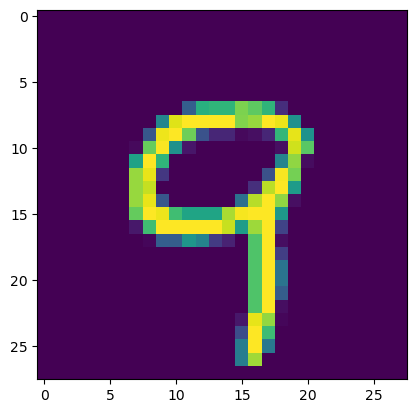

In [7]:
img_class = 9
idx = np.where(labels == img_class)[0][12]
img = inputs[idx]
plot_img(img)

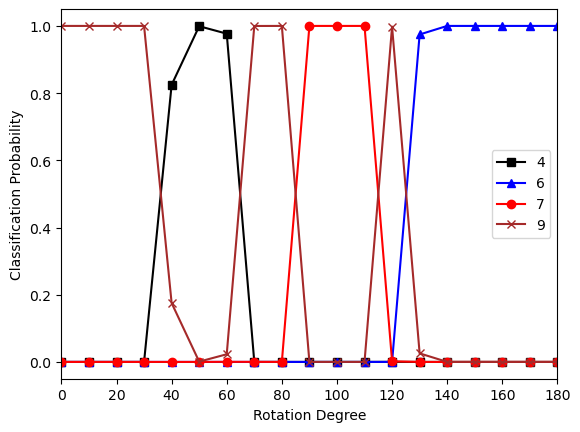

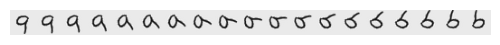

In [8]:
plot_util(img, clf)

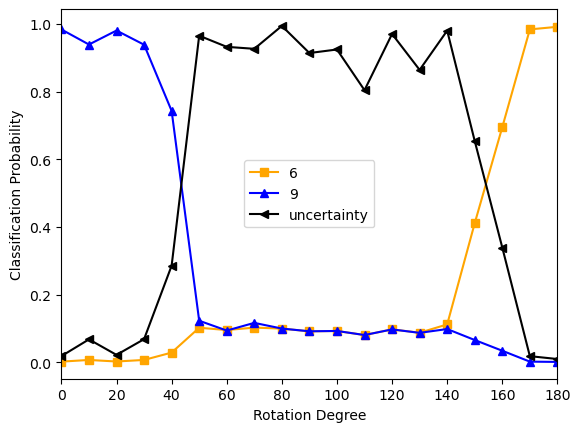

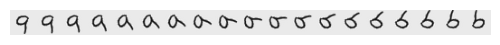

array([[1.81719474e-03, 9.83642638e-01],
       [6.76297117e-03, 9.39097464e-01],
       [2.17470108e-03, 9.80430067e-01],
       [6.82074064e-03, 9.38545167e-01],
       [2.85414811e-02, 7.43039131e-01],
       [1.01907089e-01, 1.22694336e-01],
       [9.52218324e-02, 9.36486050e-02],
       [1.02345914e-01, 1.16373815e-01],
       [9.94520411e-02, 9.95458588e-02],
       [9.13938433e-02, 9.14663449e-02],
       [9.24410075e-02, 9.24409851e-02],
       [8.04149359e-02, 8.04148614e-02],
       [9.70619991e-02, 9.70395133e-02],
       [8.73158872e-02, 8.68740454e-02],
       [1.11740753e-01, 9.81470048e-02],
       [4.11081880e-01, 6.56698644e-02],
       [6.94784701e-01, 3.39736342e-02],
       [9.83811259e-01, 1.79881719e-03],
       [9.91458535e-01, 9.49063862e-04]], dtype=float32)

In [9]:
edl_plot_util(img, edl_clf)

In [18]:
clf_model_metrics = pd.read_csv('../model_metrics/edl/clf_model_metrics.csv')
edl_clf_model_metrics = pd.read_csv('../model_metrics/edl/edl_clf_model_metrics.csv')
edl_clf_model_metrics_reg = pd.read_csv('../model_metrics/edl/edl_clf_model_metrics_reg.csv')

Text(0.5, 0, 'Iteration')

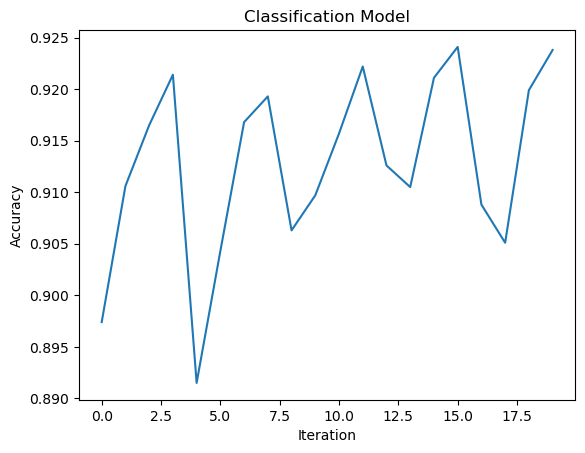

In [19]:
plt.title('Classification Model')
plt.plot(range(len(clf_model_metrics)), clf_model_metrics['accuracy'].values)
plt.ylabel('Accuracy')
plt.xlabel('Iteration')


Text(0.5, 0, 'Iteration')

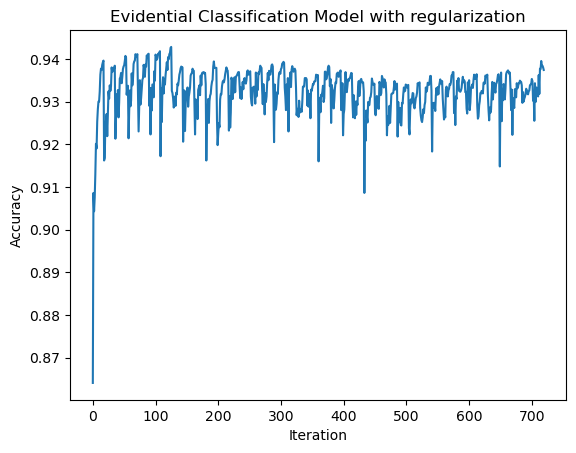

In [20]:
plt.title('Evidential Classification Model with regularization')
plt.plot(range(len(edl_clf_model_metrics_reg)), edl_clf_model_metrics_reg['accuracy'].values)
plt.ylabel('Accuracy')
plt.xlabel('Iteration')

Text(0.5, 0, 'Iteration')

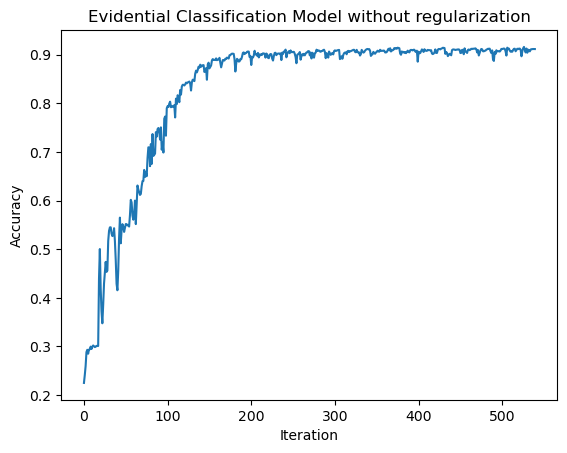

In [21]:
plt.title('Evidential Classification Model without regularization')
plt.plot(range(len(edl_clf_model_metrics)), edl_clf_model_metrics['accuracy'].values)
plt.ylabel('Accuracy')
plt.xlabel('Iteration')


Text(0.5, 1.0, 'Evidential Classification Model with regularization')

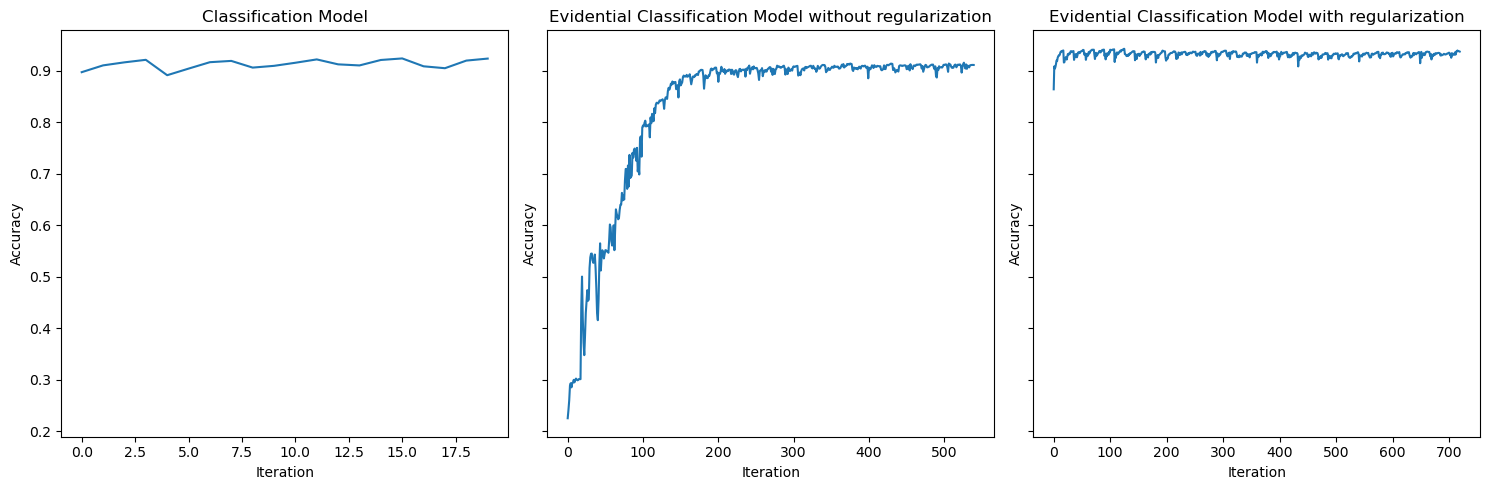

In [31]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5), tight_layout=True, sharey=True)
ax[0].plot(range(len(clf_model_metrics)), clf_model_metrics['accuracy'].values)
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Iteration')
ax[0].set_title('Classification Model')
ax[1].plot(range(len(edl_clf_model_metrics)), edl_clf_model_metrics['accuracy'].values)
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Iteration')
ax[1].set_title('Evidential Classification Model without regularization')
ax[2].plot(range(len(edl_clf_model_metrics_reg)), edl_clf_model_metrics_reg['accuracy'].values)
ax[2].set_ylabel('Accuracy')
ax[2].set_xlabel('Iteration')
ax[2].set_title('Evidential Classification Model with regularization')


Text(0.5, 1.0, 'EDL model loss with regularization')

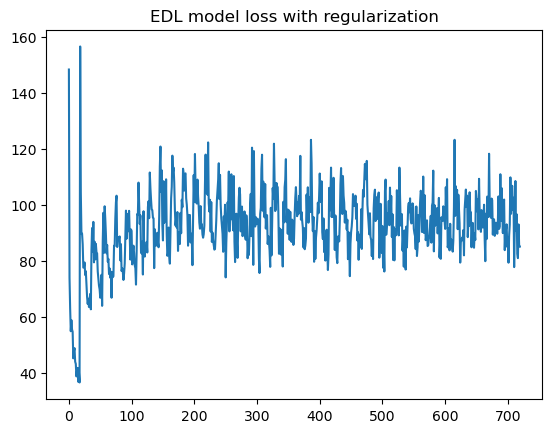

In [23]:
plt.plot(edl_clf_model_metrics_reg['loss'])
plt.title('EDL model loss with regularization')

Text(0.5, 1.0, 'EDL model loss without regularization')

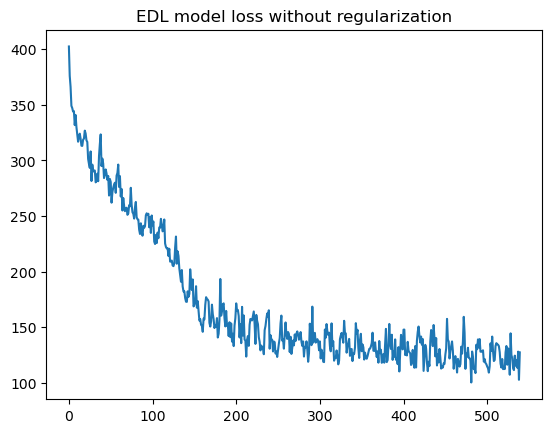

In [24]:
plt.plot(edl_clf_model_metrics['loss'])
plt.title('EDL model loss without regularization')

Text(0.5, 1.0, 'Evidential Classification Model with regularization')

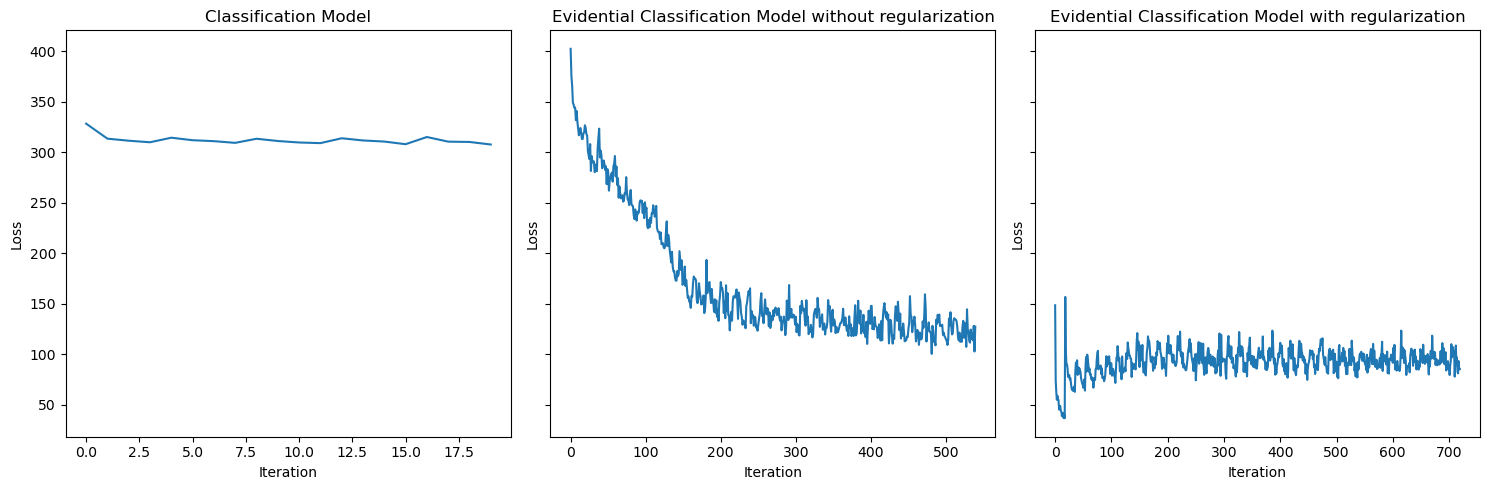

In [30]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5), tight_layout=True, sharey=True)
ax[0].plot(range(len(clf_model_metrics)), clf_model_metrics['loss'].values)
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Iteration')
ax[0].set_title('Classification Model')
ax[1].plot(range(len(edl_clf_model_metrics)), edl_clf_model_metrics['loss'].values)
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Iteration')
ax[1].set_title('Evidential Classification Model without regularization')
ax[2].plot(range(len(edl_clf_model_metrics_reg)), edl_clf_model_metrics_reg['loss'].values)
ax[2].set_ylabel('Loss')
ax[2].set_xlabel('Iteration')
ax[2].set_title('Evidential Classification Model with regularization')
